DATA ROOT CONTENTS: ['Bicycle', 'Bike', 'Boat', 'Bus', 'Car', 'Cng', 'Easy-bike', 'Horse-cart', 'Leguna', 'Rickshaw', 'Tractor', 'Truck', 'Van', 'Wheelbarrow']
VEHICLE CLASS FOLDERS: ['Bicycle', 'Bike', 'Boat', 'Bus', 'Car', 'Cng', 'Easy-bike', 'Horse-cart', 'Leguna', 'Rickshaw', 'Tractor', 'Truck', 'Van', 'Wheelbarrow']
Using device: cuda
Found classes: ['Bicycle', 'Bike', 'Boat', 'Bus', 'Car', 'Cng', 'Easy-bike', 'Horse-cart', 'Leguna', 'Rickshaw', 'Tractor', 'Truck', 'Van', 'Wheelbarrow']
TOTAL SAMPLES: 7474
TRAIN: 5231 | VAL: 1121 | TEST: 1122
Built expert efficientnet_b0 with 4.03M params
Built expert efficientnet_b1 with 6.53M params
Built expert efficientnet_b2 with 7.72M params

=== Training Expert 1/3 ===


C:\Users\Abdullah\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[Trial 1/1] Train=0.576, Val=0.816
[Full 1/2] Train=0.878, Val=0.920
[Full 2/2] Train=0.948, Val=0.953

=== Training Expert 2/3 ===
[Trial 1/1] Train=0.563, Val=0.814
[Full 1/2] Train=0.877, Val=0.902
[Full 2/2] Train=0.954, Val=0.930

=== Training Expert 3/3 ===
[Trial 1/1] Train=0.605, Val=0.850
[Full 1/2] Train=0.901, Val=0.928
[Full 2/2] Train=0.955, Val=0.951

Validation scores: [0.9527207850133809, 0.9295272078501338, 0.9509366636931311]

=== Pruning Expert 1 (ratio search) ===

  -> Trying prune ratio = 0.05
     Params: 4.03M → 4.03M
     [FT 1/3] Train=0.099
     [FT 2/3] Train=0.095
     [FT 3/3] Train=0.095
     After prune FT: Val=0.095
     ✗ Rejecting ratio 0.05 (pre_val=0.953)

  -> Trying prune ratio = 0.10
     Params: 4.03M → 4.03M
     [FT 1/3] Train=0.099
     [FT 2/3] Train=0.095
     [FT 3/3] Train=0.095
     After prune FT: Val=0.095
     ✗ Rejecting ratio 0.10 (pre_val=0.953)

  -> Trying prune ratio = 0.15
     Params: 4.03M → 4.03M
     [FT 1/3] Train=0.099
  

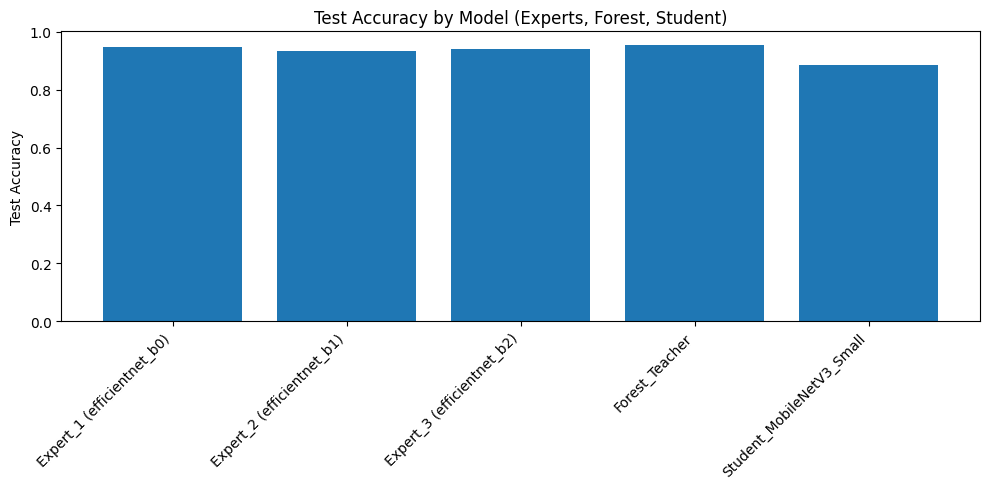

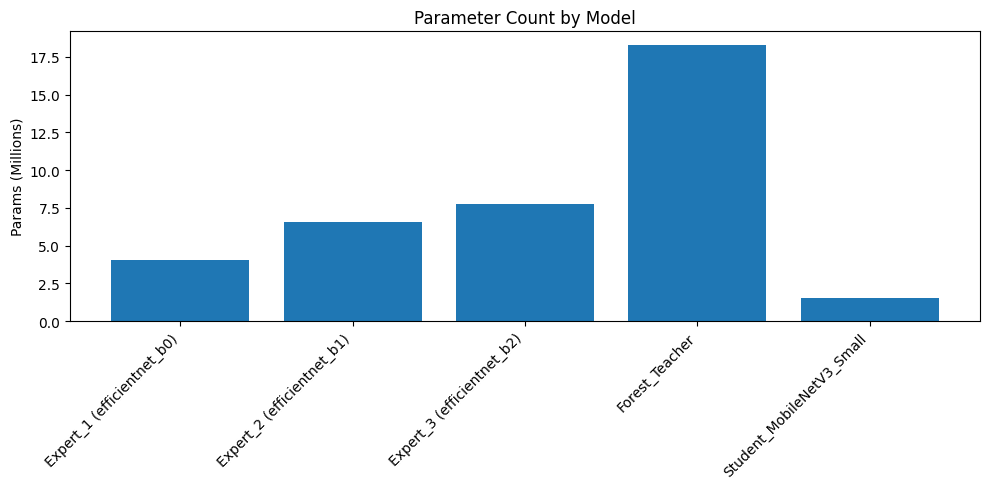

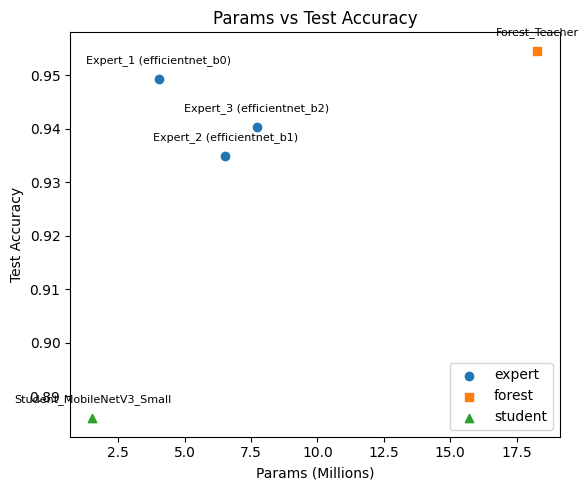

In [1]:
#%%
# ================================================================
#  SETUP — Kaggle Notebook Version (NO COLAB, NO kaggle.json)
# ================================================================
!pip install -q ptflops

import os, json, random, time, copy
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
import torch.nn.utils.prune as prune
import matplotlib.pyplot as plt
from ptflops import get_model_complexity_info

# -------------------------
#  Dataset paths (Kaggle)
# -------------------------
DATA_ROOT = r"I:\Local-Vehicles"
LOCAL_VEHICLES_DIR = DATA_ROOT

print("DATA ROOT CONTENTS:", os.listdir(DATA_ROOT))
print("VEHICLE CLASS FOLDERS:", os.listdir(LOCAL_VEHICLES_DIR))

# -------------------------
#  Reproducibility
# -------------------------
GLOBAL_SEED = 42
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
torch.manual_seed(GLOBAL_SEED)
torch.cuda.manual_seed_all(GLOBAL_SEED)

# -------------------------
#  Device
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ================================================================
#  TRANSFORMS
# ================================================================
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 0

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225],
    ),
])

eval_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225],
    ),
])

# ================================================================
#  LOAD DATA
# ================================================================
base_dataset = datasets.ImageFolder(root=LOCAL_VEHICLES_DIR, transform=None)
print("Found classes:", base_dataset.classes)
NUM_CLASSES = len(base_dataset.classes)

indices = np.arange(len(base_dataset))
labels = np.array(base_dataset.targets)

train_idx, tmp_idx, y_train, y_tmp = train_test_split(
    indices, labels, test_size=0.3, random_state=GLOBAL_SEED, stratify=labels
)
val_idx, test_idx, y_val, y_test = train_test_split(
    tmp_idx, y_tmp, test_size=0.5, random_state=GLOBAL_SEED, stratify=y_tmp
)

print(f"TOTAL SAMPLES: {len(base_dataset)}")
print(f"TRAIN: {len(train_idx)} | VAL: {len(val_idx)} | TEST: {len(test_idx)}")

# ================================================================
#  CUSTOM DATASET
# ================================================================
class IndexedImageFolder(Dataset):
    def __init__(self, base_ds, indices, transform=None):
        self.base = base_ds
        self.indices = list(indices)
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        img, label = self.base[self.indices[i]]
        img = img.convert("RGB")  # ensure RGB
        if self.transform is not None:
            img = self.transform(img)
        return img, label

train_dataset_global = IndexedImageFolder(base_dataset, train_idx, transform=train_transform)
val_dataset_global   = IndexedImageFolder(base_dataset, val_idx,   transform=eval_transform)
test_dataset_global  = IndexedImageFolder(base_dataset, test_idx,  transform=eval_transform)

train_loader_global = DataLoader(train_dataset_global, batch_size=BATCH_SIZE,
                                 shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader_global   = DataLoader(val_dataset_global, batch_size=BATCH_SIZE,
                                 shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader_global  = DataLoader(test_dataset_global, batch_size=BATCH_SIZE,
                                 shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# ================================================================
#  CONFIG
# ================================================================
EXPERT_BACKBONES = ["efficientnet_b0", "efficientnet_b1", "efficientnet_b2"]
NUM_EXPERTS = len(EXPERT_BACKBONES)
BOOTSTRAP_RATIO = 0.7

TRIAL_EPOCHS = 1
FULL_EPOCHS  = 2

LAMBDA_GL = 1e-5

# pruning config: we will SEARCH over these ratios per expert
PRUNE_RATIOS = [0.05, 0.10, 0.15]
PRUNE_FT_EPOCHS = 3

KD_TEMPERATURE = 4.0
KD_ALPHA = 0.3
KD_EPOCHS = 3

LR_EXPERT = 1e-4
LR_STUDENT = 1e-3

criterion_ce = nn.CrossEntropyLoss()

# ================================================================
#  UTILS: PARAM COUNT, FLOPs, LATENCY
# ================================================================
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def group_lasso_penalty(model):
    gl = 0.0
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            w = m.weight
            w_norm = w.pow(2).sum(dim=(1, 2, 3)).sqrt()
            gl += w_norm.sum()
    return gl

def compute_flops(model, img_size=224):
    """
    Returns (GMACs, MParams) using ptflops.
    """
    model_cpu = copy.deepcopy(model).to("cpu")
    model_cpu.eval()
    with torch.no_grad():
        macs, params = get_model_complexity_info(
            model_cpu, (3, img_size, img_size),
            as_strings=False,
            print_per_layer_stat=False
        )
    gmacs = macs / 1e9
    mparams = params / 1e6
    return gmacs, mparams

def measure_latency(model, device="cpu", runs=100):
    """
    Simple forward-pass latency in ms for a single 224x224 RGB image.
    """
    model = model.to(device)
    model.eval()
    dummy = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)

    # warmup
    with torch.no_grad():
        for _ in range(20):
            _ = model(dummy)

    start = time.time()
    with torch.no_grad():
        for _ in range(runs):
            _ = model(dummy)
    end = time.time()

    latency_ms = (end - start) / runs * 1000.0
    return latency_ms

# ================================================================
#  BUILD MODELS
# ================================================================
def build_efficientnet_expert(name, num_classes):
    if name == "efficientnet_b0":
        m = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    elif name == "efficientnet_b1":
        m = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.IMAGENET1K_V1)
    elif name == "efficientnet_b2":
        m = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.IMAGENET1K_V1)
    else:
        raise ValueError("Unknown EfficientNet variant")

    in_features = m.classifier[-1].in_features
    m.classifier[-1] = nn.Linear(in_features, num_classes)
    return m.to(device)

def build_student_model(num_classes):
    m = models.mobilenet_v3_small(
        weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1
    )
    in_features = m.classifier[-1].in_features
    m.classifier[-1] = nn.Linear(in_features, num_classes)
    return m.to(device)

# ================================================================
#  TRAIN / EVAL LOOPS
# ================================================================
def train_one_epoch_single_model(model, dataloader, optimizer, criterion, device, lambda_gl=0.0):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        out = model(images)
        ce_loss = criterion(out, labels)

        loss = ce_loss + lambda_gl * group_lasso_penalty(model)
        loss.backward()
        optimizer.step()

        total_loss += ce_loss.item() * images.size(0)
        total_correct += (out.argmax(1) == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, total_correct / total

def evaluate_single_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            out = model(images)
            loss = criterion(out, labels)

            total_loss += loss.item() * images.size(0)
            total_correct += (out.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return total_loss / total, total_correct / total

def eval_model_top1(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

def eval_forest_top1(experts, dataloader, device, weights=None):
    for m in experts:
        m.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            logits = torch.stack([m(images) for m in experts])  # [E,B,C]
            if weights is not None:
                w = weights.view(-1, 1, 1)
                logits = logits * w
                logits = logits.sum(0)
            else:
                logits = logits.mean(0)
            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

# ================================================================
#  STRUCTURED CHANNEL PRUNING
# ================================================================
def structured_channel_prune(model, amount):
    """
    Channel-wise structured pruning for Conv2d layers.
    `amount` is the fraction of channels (per layer) to prune.
    """
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            prune.ln_structured(m, name="weight", amount=amount, n=2, dim=0)
            prune.remove(m, "weight")

# ================================================================
#  TRAIN EXPERT MODELS
# ================================================================
experts = []
for name in EXPERT_BACKBONES:
    model = build_efficientnet_expert(name, NUM_CLASSES)
    print(f"Built expert {name} with {count_params(model)/1e6:.2f}M params")
    experts.append(model)

expert_val_scores = []

for i, expert in enumerate(experts):
    print(f"\n=== Training Expert {i+1}/{NUM_EXPERTS} ===")

    n_train = len(train_dataset_global)
    sub_size = int(BOOTSTRAP_RATIO * n_train)
    sub_idx = np.random.choice(np.arange(n_train), size=sub_size, replace=True)
    train_subset = torch.utils.data.Subset(train_dataset_global, sub_idx)

    train_loader_expert = DataLoader(
        train_subset, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=NUM_WORKERS, pin_memory=True
    )

    optimizer = torch.optim.AdamW(expert.parameters(), lr=LR_EXPERT, weight_decay=1e-4)

    # Trial training
    for epoch in range(1, TRIAL_EPOCHS + 1):
        t_loss, t_acc = train_one_epoch_single_model(
            expert, train_loader_expert, optimizer, criterion_ce, device, LAMBDA_GL
        )
        v_loss, v_acc = evaluate_single_model(expert, val_loader_global, criterion_ce, device)
        print(f"[Trial {epoch}/{TRIAL_EPOCHS}] Train={t_acc:.3f}, Val={v_acc:.3f}")

    # Full training
    for epoch in range(1, FULL_EPOCHS + 1):
        t_loss, t_acc = train_one_epoch_single_model(
            expert, train_loader_expert, optimizer, criterion_ce, device, LAMBDA_GL
        )
        v_loss, v_acc = evaluate_single_model(expert, val_loader_global, criterion_ce, device)
        print(f"[Full {epoch}/{FULL_EPOCHS}] Train={t_acc:.3f}, Val={v_acc:.3f}")

    expert_val_scores.append(v_acc)

print("\nValidation scores:", expert_val_scores)

# ================================================================
#  PRUNE EXPERTS (ratio search + rollback if accuracy collapses)
# ================================================================
for i, expert in enumerate(experts):
    print(f"\n=== Pruning Expert {i+1} (ratio search) ===")
    base_params = count_params(expert)
    pre_val = expert_val_scores[i]
    base_state = copy.deepcopy(expert.state_dict())  # original weights

    best_val = pre_val
    best_ratio = 0.0
    best_state = base_state
    best_params = base_params

    for ratio in PRUNE_RATIOS:
        print(f"\n  -> Trying prune ratio = {ratio:.2f}")
        # work on a copy so we don't destroy the current best
        temp_model = copy.deepcopy(expert)
        structured_channel_prune(temp_model, ratio)
        pruned_params = count_params(temp_model)
        print(f"     Params: {base_params/1e6:.2f}M → {pruned_params/1e6:.2f}M")

        optimizer = torch.optim.AdamW(temp_model.parameters(), lr=LR_EXPERT)
        # fine-tune after pruning
        for ft_epoch in range(1, PRUNE_FT_EPOCHS + 1):
            t_loss, t_acc = train_one_epoch_single_model(
                temp_model, train_loader_global, optimizer, criterion_ce, device, lambda_gl=0.0
            )
            print(f"     [FT {ft_epoch}/{PRUNE_FT_EPOCHS}] Train={t_acc:.3f}")

        v_loss, v_acc = evaluate_single_model(temp_model, val_loader_global, criterion_ce, device)
        print(f"     After prune FT: Val={v_acc:.3f}")

        # only accept if not collapsing too much and better than best so far
        if v_acc >= pre_val * 0.95 and v_acc > best_val:
            print(f"     ✓ Accepting ratio {ratio:.2f} (prev best {best_val:.3f} → {v_acc:.3f})")
            best_val = v_acc
            best_ratio = ratio
            best_state = copy.deepcopy(temp_model.state_dict())
            best_params = pruned_params
        else:
            print(f"     ✗ Rejecting ratio {ratio:.2f} (pre_val={pre_val:.3f})")

    if best_ratio > 0.0:
        print(f"\nChosen prune ratio for Expert {i+1}: {best_ratio:.2f}")
        print(f"Params: {base_params/1e6:.2f}M → {best_params/1e6:.2f}M")
        expert.load_state_dict(best_state)
        expert_val_scores[i] = best_val
    else:
        print(f"\nNo acceptable pruning ratio found for Expert {i+1}, keeping original weights.")
        expert.load_state_dict(base_state)  # ensure original
        # expert_val_scores[i] stays as pre_val

# ================================================================
#  FOREST WEIGHTS
# ================================================================
val_scores = np.array(expert_val_scores)
forest_weights_np = val_scores / val_scores.sum() if val_scores.sum() > 0 else np.ones_like(val_scores) / len(val_scores)
forest_weights = torch.tensor(forest_weights_np, dtype=torch.float32, device=device)
print("\nForest Weights:", forest_weights.cpu().tolist())

def forest_logits(experts, images, weights=None):
    for m in experts:
        m.eval()
    with torch.no_grad():
        logits = torch.stack([m(images) for m in experts])
    if weights is None:
        return logits.mean(0)
    return (logits * weights.view(-1, 1, 1)).sum(0)

# ================================================================
#  STUDENT MODEL (MobileNetV3) + KNOWLEDGE DISTILLATION
# ================================================================
student = build_student_model(NUM_CLASSES)
print("Student params:", count_params(student)/1e6, "M")

def kd_loss_fn(s_logits, t_logits, labels, T, alpha):
    ce = criterion_ce(s_logits, labels)
    log_p_s = F.log_softmax(s_logits / T, dim=1)
    p_t = F.softmax(t_logits / T, dim=1)
    kd = F.kl_div(log_p_s, p_t, reduction="batchmean") * (T**2)
    return alpha * ce + (1 - alpha) * kd, ce, kd

optimizer_student = torch.optim.AdamW(student.parameters(), lr=LR_STUDENT)

print("\n=== TRAINING STUDENT WITH KD ===")
for epoch in range(1, KD_EPOCHS + 1):
    student.train()
    total_correct = 0
    total = 0
    total_loss = 0.0

    for images, labels in train_loader_global:
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            t_logits = forest_logits(experts, images, weights=forest_weights)

        optimizer_student.zero_grad()
        s_logits = student(images)
        loss, ce, kd = kd_loss_fn(s_logits, t_logits, labels, KD_TEMPERATURE, KD_ALPHA)
        loss.backward()
        optimizer_student.step()

        total_loss += loss.item() * images.size(0)
        total_correct += (s_logits.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_acc = total_correct / total
    val_acc = evaluate_single_model(student, val_loader_global, criterion_ce, device)[1]

    print(f"[KD {epoch}/{KD_EPOCHS}] Train Acc={train_acc:.3f}, Val Acc={val_acc:.3f}")

# ================================================================
#  TEST ACCURACY
# ================================================================
test_acc = evaluate_single_model(student, test_loader_global, criterion_ce, device)[1]
print("\nFinal Student Test Accuracy:", test_acc)
forest_total_params = sum(count_params(e) for e in experts) / 1e6
print("Forest params:", forest_total_params, "M")
print("Student params:", count_params(student)/1e6, "M")

#%%
# ================================================================
#  BENCHMARKING & PLOTS (run AFTER training & KD)
# ================================================================
# Collect metrics for experts, forest, and student
rows = []

# Individual experts
for i, (name, expert) in enumerate(zip(EXPERT_BACKBONES, experts), start=1):
    val_acc = eval_model_top1(expert, val_loader_global, device)
    test_acc = eval_model_top1(expert, test_loader_global, device)
    params_m = count_params(expert) / 1e6

    rows.append({
        "model": f"Expert_{i} ({name})",
        "role": "expert",
        "params_M": params_m,
        "val_acc": val_acc,
        "test_acc": test_acc,
    })

# Forest teacher (ensemble)
forest_params_m = sum(count_params(e) for e in experts) / 1e6
forest_val_acc = eval_forest_top1(experts, val_loader_global, device, weights=forest_weights)
forest_test_acc = eval_forest_top1(experts, test_loader_global, device, weights=forest_weights)

rows.append({
    "model": "Forest_Teacher",
    "role": "forest",
    "params_M": forest_params_m,
    "val_acc": forest_val_acc,
    "test_acc": forest_test_acc,
})

# Student (KD MobileNetV3-Small)
student_val_acc = eval_model_top1(student, val_loader_global, device)
student_test_acc = eval_model_top1(student, test_loader_global, device)
student_params_m = count_params(student) / 1e6

rows.append({
    "model": "Student_MobileNetV3_Small",
    "role": "student",
    "params_M": student_params_m,
    "val_acc": student_val_acc,
    "test_acc": student_test_acc,
})

# ------------------------------------------------
# DataFrame + CSV
# ------------------------------------------------
results_df = pd.DataFrame(rows)
print("\n=== BENCHMARK RESULTS ===")
print(results_df)

results_df.to_csv("benchmark_results.csv", index=False)
print("\nSaved benchmark_results.csv")

# ------------------------------------------------
# Plot 1: Test accuracy bar plot
# ------------------------------------------------
plt.figure(figsize=(10, 5))
plt.bar(results_df["model"], results_df["test_acc"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy by Model (Experts, Forest, Student)")
plt.tight_layout()
plt.show()

# ------------------------------------------------
# Plot 2: Parameter counts bar plot
# ------------------------------------------------
plt.figure(figsize=(10, 5))
plt.bar(results_df["model"], results_df["params_M"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Params (Millions)")
plt.title("Parameter Count by Model")
plt.tight_layout()
plt.show()

# ------------------------------------------------
# Plot 3: Params vs Test Accuracy scatter
# ------------------------------------------------
plt.figure(figsize=(6, 5))
for role, marker in [("expert", "o"), ("forest", "s"), ("student", "^")]:
    subset = results_df[results_df["role"] == role]
    if len(subset) == 0:
        continue
    plt.scatter(subset["params_M"], subset["test_acc"], label=role, marker=marker)

for _, row in results_df.iterrows():
    plt.text(row["params_M"], row["test_acc"] + 0.003, row["model"],
             fontsize=8, ha="center")

plt.xlabel("Params (Millions)")
plt.ylabel("Test Accuracy")
plt.title("Params vs Test Accuracy")
plt.legend()
plt.tight_layout()
plt.show()


In [3]:
# ==== FLOPs + Latency measurement ====
flops_rows = []

all_models = [
    ("Expert_1 (efficientnet_b0)", "expert", experts[0]),
    ("Expert_2 (efficientnet_b1)", "expert", experts[1]),
    ("Expert_3 (efficientnet_b2)", "expert", experts[2]),
    ("Forest_Teacher", "forest", None),      # handle separately
    ("Student_MobileNetV3_Small", "student", student),
]

for name, role, model in all_models:
    if role == "forest":
        # approximate FLOPs as sum of experts
        gmacs = 0.0
        for e in experts:
            gm, _ = compute_flops(e, img_size=IMG_SIZE)
            gmacs += gm
        latency = None  # you can leave this blank or approximate similarly
    else:
        gm, _ = compute_flops(model, img_size=IMG_SIZE)
        gmacs = gm  # <-- FIX: make sure gmacs is defined for non-forest models
        # measure latency on GPU if available, else CPU
        lat_device = device if device.type == "cuda" else "cpu"
        latency = measure_latency(model, device=lat_device, runs=50)

    flops_rows.append({
        "model": name,
        "role": role,
        "gmacs": gmacs,
        "latency_ms": latency,
    })

flops_df = pd.DataFrame(flops_rows)
print(flops_df)

# Merge with accuracy table
full_df = results_df.merge(flops_df, on=["model","role"], how="left")
print("\n=== FULL METRICS (acc + params + FLOPs + latency) ===")
print(full_df)
full_df.to_csv("full_benchmark_results.csv", index=False)


                        model     role     gmacs  latency_ms
0  Expert_1 (efficientnet_b0)   expert  0.408934    6.403942
1  Expert_2 (efficientnet_b1)   expert  0.602648    7.822838
2  Expert_3 (efficientnet_b2)   expert  0.693535    7.811341
3              Forest_Teacher   forest  1.705117         NaN
4   Student_MobileNetV3_Small  student  0.059899    4.500318

=== FULL METRICS (acc + params + FLOPs + latency) ===
                        model     role   params_M   val_acc  test_acc  \
0  Expert_1 (efficientnet_b0)   expert   4.025482  0.952721  0.949198   
1  Expert_2 (efficientnet_b1)   expert   6.531118  0.929527  0.934938   
2  Expert_3 (efficientnet_b2)   expert   7.720720  0.950937  0.940285   
3              Forest_Teacher   forest  18.277320  0.959857  0.954545   
4   Student_MobileNetV3_Small  student   1.532206  0.892061  0.885918   

      gmacs  latency_ms  
0  0.408934    6.403942  
1  0.602648    7.822838  
2  0.693535    7.811341  
3  1.705117         NaN  
4  0.05989

In [4]:
# ================================================================
#  TEASER NUMBERS: FLOPs reduction, params reduction, accuracy retention
# ================================================================

import numpy as np

def compute_teaser_numbers(df, baseline_name, student_name):
    """Compute teaser numbers comparing a student to a baseline model."""
    base = df[df["model"] == baseline_name].iloc[0]
    stud = df[df["model"] == student_name].iloc[0]

    # Params and FLOPs reduction (percentage)
    params_reduction = 100.0 * (1.0 - stud["params_M"] / base["params_M"])
    flops_reduction  = 100.0 * (1.0 - stud["gmacs"]    / base["gmacs"])

    # Accuracy retention (percentage of baseline accuracy kept)
    acc_retention = 100.0 * stud["test_acc"] / base["test_acc"]
    acc_drop      = (stud["test_acc"] - base["test_acc"]) * 100.0  # in percentage points

    return {
        "baseline": baseline_name,
        "student": student_name,
        "baseline_params_M": base["params_M"],
        "student_params_M": stud["params_M"],
        "baseline_gmacs": base["gmacs"],
        "student_gmacs": stud["gmacs"],
        "baseline_test_acc": base["test_acc"],
        "student_test_acc": stud["test_acc"],
        "params_reduction_%": params_reduction,
        "flops_reduction_%": flops_reduction,
        "accuracy_retention_%": acc_retention,
        "accuracy_drop_pp": acc_drop,
    }

# ------------------------------------------------
# Choose baselines
# ------------------------------------------------

# 1) Forest teacher as main baseline
forest_name = "Forest_Teacher"

# 2) Best single expert as another baseline
experts_df = full_df[full_df["role"] == "expert"]
best_expert_row = experts_df.loc[experts_df["test_acc"].idxmax()]
best_expert_name = best_expert_row["model"]

# 3) Student model name (as used in your tables)
student_name = "Student_MobileNetV3_Small"

# ------------------------------------------------
# Compute teaser numbers
# ------------------------------------------------
teaser_forest = compute_teaser_numbers(full_df, forest_name, student_name)
teaser_expert = compute_teaser_numbers(full_df, best_expert_name, student_name)

print("=== TEASER vs Forest Teacher ===")
print(f"Baseline: {teaser_forest['baseline']}")
print(f"Student : {teaser_forest['student']}")
print(f"Params reduction: {teaser_forest['params_reduction_%']:.1f}%")
print(f"FLOPs reduction : {teaser_forest['flops_reduction_%']:.1f}%")
print(f"Accuracy retention: {teaser_forest['accuracy_retention_%']:.2f}% "
      f"(Δ {teaser_forest['accuracy_drop_pp']:+.2f} pts)")

print("\n=== TEASER vs Best Expert ===")
print(f"Baseline: {teaser_expert['baseline']}")
print(f"Student : {teaser_expert['student']}")
print(f"Params reduction: {teaser_expert['params_reduction_%']:.1f}%")
print(f"FLOPs reduction : {teaser_expert['flops_reduction_%']:.1f}%")
print(f"Accuracy retention: {teaser_expert['accuracy_retention_%']:.2f}% "
      f"(Δ {teaser_expert['accuracy_drop_pp']:+.2f} pts)")

# Optionally save teaser numbers to CSV
teaser_df = pd.DataFrame([teaser_forest, teaser_expert])
teaser_df.to_csv("teaser_numbers.csv", index=False)
print("\nSaved teaser_numbers.csv")
print(teaser_df)


=== TEASER vs Forest Teacher ===
Baseline: Forest_Teacher
Student : Student_MobileNetV3_Small
Params reduction: 91.6%
FLOPs reduction : 96.5%
Accuracy retention: 92.81% (Δ -6.86 pts)

=== TEASER vs Best Expert ===
Baseline: Expert_1 (efficientnet_b0)
Student : Student_MobileNetV3_Small
Params reduction: 61.9%
FLOPs reduction : 85.4%
Accuracy retention: 93.33% (Δ -6.33 pts)

Saved teaser_numbers.csv
                     baseline                    student  baseline_params_M  \
0              Forest_Teacher  Student_MobileNetV3_Small          18.277320   
1  Expert_1 (efficientnet_b0)  Student_MobileNetV3_Small           4.025482   

   student_params_M  baseline_gmacs  student_gmacs  baseline_test_acc  \
0          1.532206        1.705117       0.059899           0.954545   
1          1.532206        0.408934       0.059899           0.949198   

   student_test_acc  params_reduction_%  flops_reduction_%  \
0          0.885918           91.616900          96.487081   
1          0.885